**Author**: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

The PyMC3 model is adapted from https://github.com/pymc-devs/resources/blob/master/BCM/CaseStudies/PsychophysicalFunctions.ipynb


In [1]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.11.1
! pip install numpyro

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy.stats import norm
from ipywidgets import widgets
from IPython.display import display

sns.set_context('talk')

# Fitting a psychometric function at the group level

In this example, we are going to fit a cummulative normal function to decision responses made during the Heart Rate Discrimination task. We will use the data from the [HRD method paper](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) (Legrand et al., 2021) and analyse the responses from all participants and infer group-level hyperpriors.

In [2]:
# Load data frame
psychophysics_df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

First, let's filter this data frame so we only keep the interoceptive condition (`Extero` label).

In [3]:
this_df = psychophysics_df[psychophysics_df.Modality == 'Intero']
this_df.head()

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier,Subject
0,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.933293,99.0,0.512461,-30.0,66.5,...,NaN,NaN,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,False,sub_0019
2,psiCatchTrial,More,Intero,psiCatchTrial,Less,3.099441,25.0,0.729331,10.0,67.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
4,psi,Less,Intero,psi,Less,2.099316,41.0,1.243842,-0.5,65.5,...,22.805550,12.549457,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
5,psi,More,Intero,psi,More,1.283556,68.0,1.058548,22.5,65.5,...,10.001882,12.884902,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
7,psi,More,Intero,psi,Less,3.166090,4.0,1.254876,10.5,67.5,...,18.938407,12.726249,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019


In [4]:
len(this_df.Subject.unique())
#this_df[this_df[this_df.Modality == 'Intero'].Subject == 'sub_0019']
this_df[this_df.Subject == 'sub_0019'].drop(['StartListening',
       'StartDecision', 'ResponseMade', 'RatingStart', 'RatingEnds',
       'endTrigger'],axis = 1)

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,responseBPM,ResponseCorrect,DecisionProvided,RatingProvided,nTrials,EstimatedThreshold,EstimatedSlope,HeartRateOutlier,Subject
0,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.933293,99.0,0.512461,-30.0,66.5,36.5,1.0,True,True,0,NaN,NaN,False,sub_0019
2,psiCatchTrial,More,Intero,psiCatchTrial,Less,3.099441,25.0,0.729331,10.0,67.0,77.0,0.0,True,True,2,NaN,NaN,False,sub_0019
4,psi,Less,Intero,psi,Less,2.099316,41.0,1.243842,-0.5,65.5,65.0,1.0,True,True,4,22.805550,12.549457,False,sub_0019
5,psi,More,Intero,psi,More,1.283556,68.0,1.058548,22.5,65.5,88.0,1.0,True,True,5,10.001882,12.884902,False,sub_0019
7,psi,More,Intero,psi,Less,3.166090,4.0,1.254876,10.5,67.5,78.0,0.0,True,True,7,18.938407,12.726249,False,sub_0019
8,psi,More,Intero,psi,More,1.098186,79.0,0.935841,18.5,66.5,85.0,1.0,True,True,8,13.151947,11.931038,False,sub_0019
9,psi,More,Intero,psi,More,2.098430,72.0,0.783620,13.5,67.0,80.5,1.0,True,True,9,8.662620,12.356630,False,sub_0019
12,psi,More,Intero,psi,Less,3.048115,29.0,1.977722,5.5,66.0,71.5,0.0,True,True,12,11.794447,10.792284,False,sub_0019
14,psi,More,Intero,psi,Less,2.981025,20.0,2.105916,8.5,67.0,75.5,0.0,True,True,14,13.707323,9.575809,False,sub_0019
17,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.780559,100.0,0.512798,-20.0,67.5,47.5,1.0,True,True,17,NaN,NaN,False,sub_0019


This data frame contain a large number of columns, but here we will be interested in the `Alpha` column (the intensity value) and the `Decision` column (the response made by the participant).

In [5]:
this_df = this_df[['Alpha', 'Decision', 'Subject']]
this_df.head()

,Alpha,Decision,Subject
0,-30.0,Less,sub_0019
2,10.0,Less,sub_0019
4,-0.5,Less,sub_0019
5,22.5,More,sub_0019
7,10.5,Less,sub_0019


In [5]:
## A widget to scroll through the participant-level answers

# to store intensities, responses and totals
result = {'intensities':[], 'responses':[], 'totals':[]}

# loop over all subjects
for i, sub in enumerate(this_df.Subject.unique()):
    
    # subsample the df to get subject answers
    sub_df = this_df[this_df.Subject==sub]
    
    # get unique intensities
    ints_sub = np.sort(sub_df.Alpha.unique())
    # to store sub-level responses and totals
    resps_sub = np.zeros(len(ints_sub))
    totals_sub = np.zeros(len(ints_sub))
    
    # loop over each intensity
    for ii, intensity in enumerate(np.sort(sub_df.Alpha.unique())):
        # collect resp, total
        resp = sum((sub_df.Alpha == intensity) & (sub_df.Decision == 'More'))
        total = sum(sub_df.Alpha == intensity)

        resps_sub[ii] = sum((sub_df.Alpha == intensity) & (sub_df.Decision == 'More'))
        totals_sub[ii] = sum(sub_df.Alpha == intensity)

    result['intensities'].append(ints_sub)
    result['responses'].append(resps_sub)
    result['totals'].append(totals_sub)

# make df from esult dict
result_df = pd.DataFrame(result)

def plot_responses(i):
    
    # plotting code from legrand
    fig, axs = plt.subplots(figsize=(8, 5))
    
    # loop over each intensity    
    for j in range(len(result_df.iloc[i].intensities)):
        
        axs.plot(result_df.iloc[i].intensities[j], result_df.iloc[i].responses[j]/result_df.iloc[i].totals[j],
                 'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=result_df.iloc[i].totals[j]*5)

    plt.ylabel('P$_{(Response = More|Intensity)}$')
    plt.xlabel('Intensity ($\Delta$ BPM)')
    plt.tight_layout()
    #sns.despine()

widgets.interact(plot_responses, i=(0, 190))

interactive(children=(IntSlider(value=95, description='i', max=190), Output()), _dom_classes=('widget-interact…

<function __main__.plot_responses(i)>

These two columns are enought for us to extract the 3 vectors of interest to fit a psychometric function:
* The intensity vector, listing all the tested intensities values
* The total number of trials for each tested intensity value
* The number of "correct" response (here, when the decision == 'More').

Let's take a look at the data. This function will plot the proportion of "Faster" responses depending on the intensity value of the trial stimuli (expressed in BPM). Here, the size of the circle represent the number of trials that were presented for each intensity values.

# Model

<img src="https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/hierarchicalPsychophysics.png" align = 'left' alt="drawing" width="300"/>

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \Phi_{i, j}(x_{i, j}, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i, j} - \alpha}{\beta * \sqrt{2}})$$
$$ \alpha_{i} \sim \mathcal{Normal}(\mu_{\alpha}, \sigma_{\alpha})$$
$$ \beta_{i} \sim \mathcal{Normal}(\mu_{\beta}, \sigma_{\beta})$$

$$ \mu_{\alpha} \sim  \mathcal{Uniform}(-50, 50)$$
$$ \sigma_{\alpha} \sim  |\mathcal{Normal}(0, 100)|$$

$$ \mu_{\beta} \sim  \mathcal{Uniform}(0, 100)$$
$$ \sigma_{\beta} \sim  |\mathcal{Normal}(0, 100)|$$


Where $erf$ is the [error functions](https://en.wikipedia.org/wiki/Error_function), and $\Phi$ is the cumulative normal function with threshold $\alpha$ and slope $\beta$.




We create our own PyMC3 compatible cumulative normal distribution function here.

In [6]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

We preprocess the data to extract the intensity $x$, the number or trials $n$ and number of hit responses $r$. We also create a vector `sub_total` containing the participants index (from 0 to $n_{participants}$).



In [9]:
nsubj = this_df.Subject.nunique()
x_total, n_total, r_total, sub_total = [], [], [], []
full_n = np.zeros(163)
full_r = np.zeros(163)

for i, sub in enumerate(this_df.Subject.unique()):

    sub_df = this_df[this_df.Subject==sub]

    x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)
    
    for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
        x[ii] = intensity
        n[ii] = sum(sub_df.Alpha == intensity)
        r[ii] = sum((sub_df.Alpha == intensity) & (sub_df.Decision == "More"))
        
    full_n += n
    full_r += r
    
    # remove no responses trials
    validmask = n != 0
    xij, nij, rij = x[validmask], n[validmask], r[validmask]
    sub_vec = [i] * len(xij)

    x_total.extend(xij)
    n_total.extend(nij)
    r_total.extend(rij)
    sub_total.extend(sub_vec)

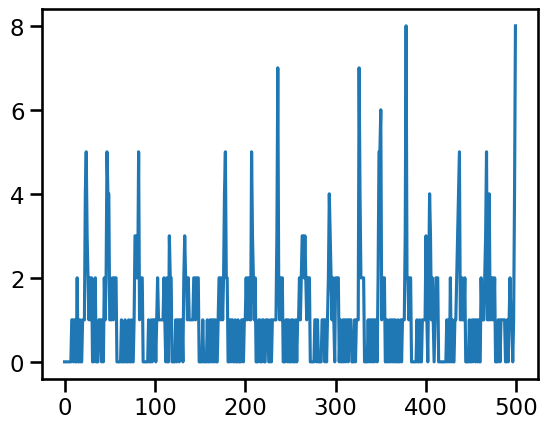

In [9]:
plt.plot(r_total[:500])

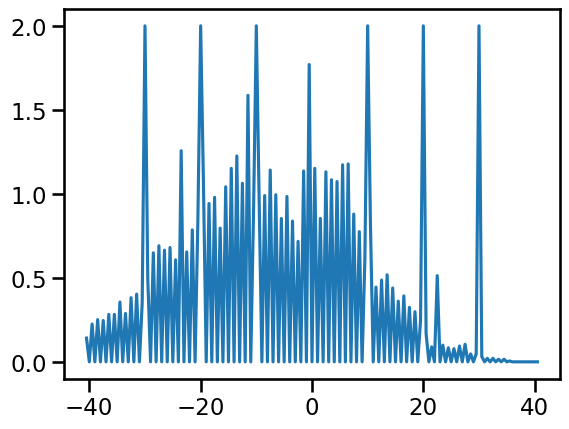

In [18]:
plt.plot(np.arange(-40.5, 41, 0.5), full_n/nsubj)
#plt.plot(np.arange(-40.5, 41, 0.5), full_r/193)

Create the model.

In [12]:
with pm.Model() as hierarchicalPsychophysics:

    mu_alpha = pm.Uniform("mu_alpha", lower=-50, upper=50)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=100)

    mu_beta = pm.Uniform("mu_beta", lower=0, upper=100)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=100)

    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, shape=nsubj)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=nsubj)

    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(x_total, alpha[sub_total], beta[sub_total])
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=r_total)

Sampling.

In [13]:
with hierarchicalPsychophysics:

    trace = pm.sample(
        chains=4, cores=4, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
The acceptance probability does not match the target. It is 9.653540164345042e-01, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'mu_alpha'}>,
        <AxesSubplot:title={'center':'mu_alpha'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'mu_beta'}>,
        <AxesSubplot:title={'center':'mu_beta'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

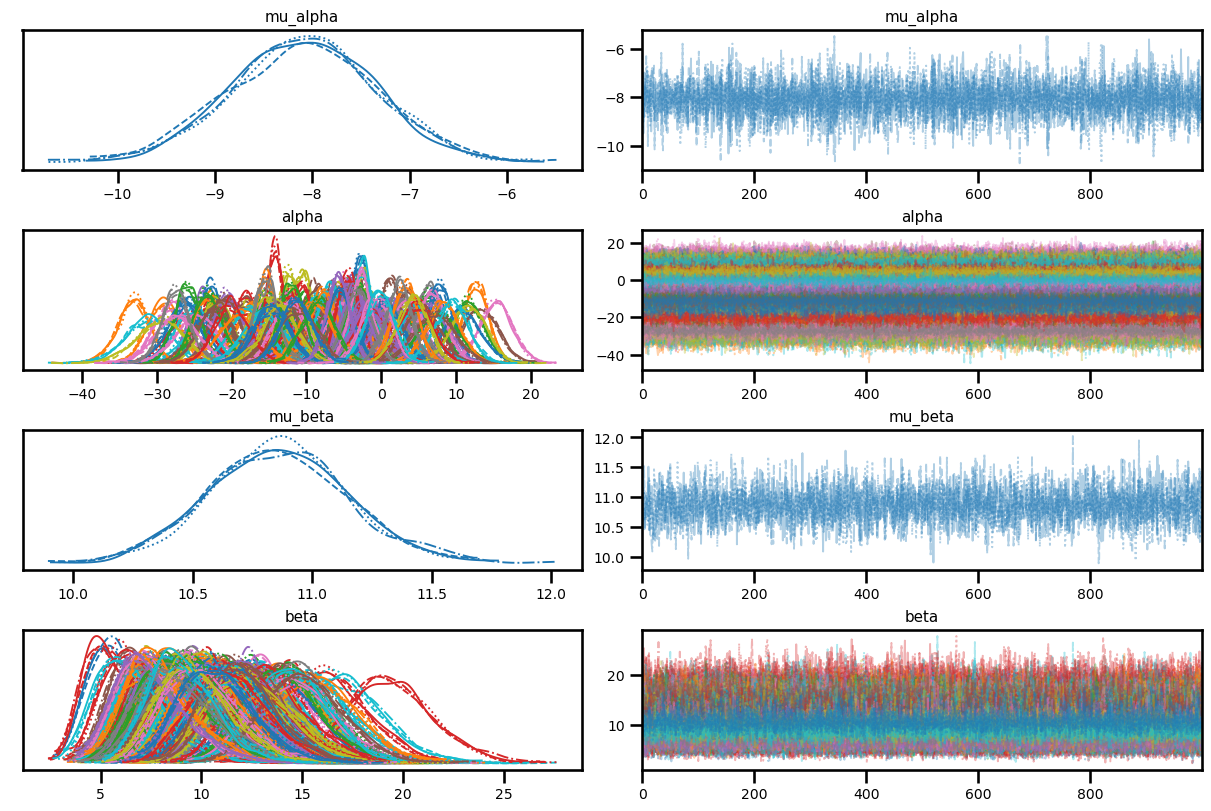

In [15]:
az.plot_trace(trace, var_names=["mu_alpha", "alpha", 'mu_beta', 'beta'])

array([[<AxesSubplot:title={'center':'sigma_alpha'}>,
        <AxesSubplot:title={'center':'sigma_alpha'}>],
       [<AxesSubplot:title={'center':'sigma_beta'}>,
        <AxesSubplot:title={'center':'sigma_beta'}>]], dtype=object)

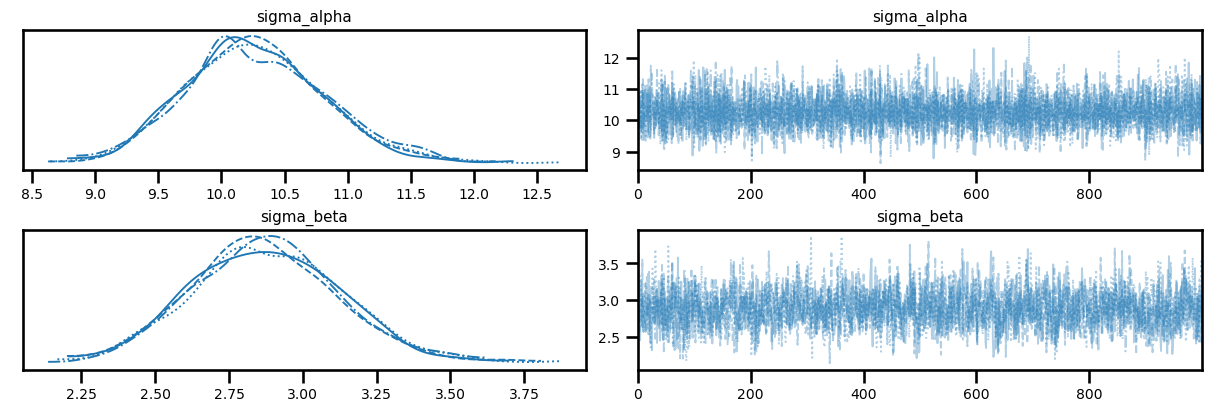

In [13]:
az.plot_trace(trace, var_names=[ 'sigma_alpha', 'sigma_beta'])

In [71]:
stats = az.summary(trace, var_names=["mu_alpha", "mu_beta", 'sigma_alpha', 'sigma_beta'])
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-8.103,0.768,-9.608,-6.730,0.009,0.006,8096.0,7966.0,8068.0,2734.0,1.0
mu_beta,10.865,0.280,10.364,11.425,0.005,0.004,3129.0,3129.0,3116.0,2939.0,1.0
sigma_alpha,10.262,0.577,9.204,11.354,0.007,0.005,7601.0,7339.0,7891.0,3016.0,1.0
sigma_beta,2.871,0.256,2.393,3.335,0.006,0.004,1653.0,1653.0,1654.0,2306.0,1.0


**Interpretation**: Here, $\alpha$ refers to the threshold value (also the point of subjective equality for this design). We can observe that the group of participants has an average threshold very close to 0 and a slope of 7, which is relatively small in this context and indicate a precise decision process. A higher value means lower precision. By looking at the posterior density of the threshold ($\alpha$), we can see that the 94% highest density interval (HDI) includes 0, suggesting that we have good evidence that no bias can be observed at the group tlevel for the exteroceptive condition.

<AxesSubplot:title={'center':'mu_alpha'}>

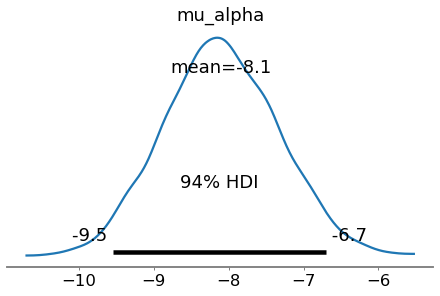

In [12]:
az.plot_posterior(trace, var_names=["mu_alpha"])

# Plotting
Extrace the individual parameters estimates.

In [13]:
alpha_samples = az.summary(trace, var_names=["alpha"])["mean"].values
beta_samples = az.summary(trace, var_names=["beta"])["mean"].values

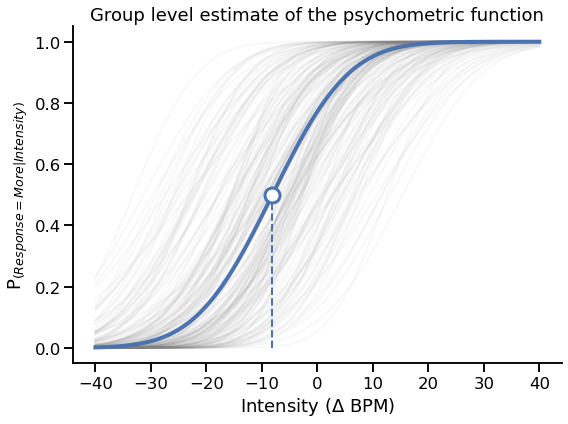

In [14]:
fig, axs = plt.subplots(figsize=(8, 6))

# Draw some sample from the traces
for a, b in zip(alpha_samples, beta_samples):
  axs.plot(np.linspace(-40, 40, 500), 
          (norm.cdf(np.linspace(-40, 40, 500), loc=a, scale=b)),
          color='gray', alpha=.05, linewidth=2)

# Plot psychometric function with average parameters
slope = az.summary(trace, var_names=["mu_beta"])['mean']['mu_beta']
threshold = az.summary(trace, var_names=["mu_alpha"])['mean']['mu_alpha']
axs.plot(np.linspace(-40, 40, 500), 
        (norm.cdf(np.linspace(-40, 40, 500), loc=threshold, scale=slope)),
         color='#4c72b0', linewidth=4)

axs.plot([threshold, threshold], [0, .5], '--', color='#4c72b0', linewidth=2)
axs.plot(threshold, .5, 'o', color='w', markeredgecolor='#4c72b0', 
         markersize=15, markeredgewidth=3)

plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.title('Group level estimate of the psychometric function')
plt.tight_layout()
sns.despine()